In [1]:
import pandas as pd
from pandas import concat
import numpy as np
import tensorflow
from tensorflow.keras.models import Sequential
from sklearn import preprocessing
from tensorflow.keras import backend as K
#from sklearn.preprocessing import MinMaxScaler
#from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Input, Dense, LSTM,GRU,SimpleRNN, Activation
from matplotlib import pyplot
#from sklearn.model_selection import train_test_split

In [2]:
"# convert series to supervised learning\n" 
#windowing of data
def series_to_supervised(data, n_in, n_out, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1),
    for i in range(n_in, 0, -1): #startes from n_in and decreses to 0 by decreasing each time -1
     cols.append(df.shift(i))
     names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
     cols.append(df.shift(-i))
     if i == 0:
       names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
     else:
       names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together\n",
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values\n",
    if dropnan:
      agg.dropna(inplace=True)
    return agg

In [3]:
#def root_mean_squared_error(y_true, y_pred):
 #       return K.sqrt(K.mean(K.square(y_pred - y_true)))


In [4]:
dataset1=pd.read_excel('F:\MS thesis data/Brooklyn.xlsx')
dataset1=dataset1.drop(['Date/Time','Flowd'],axis=1)
dataset1.dropna(inplace=True)

(26302, 3)


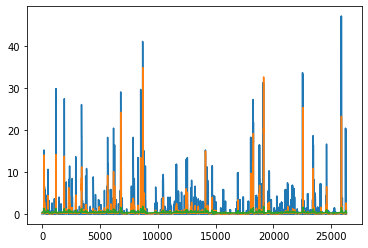

In [5]:
shape=np.shape(dataset1)
print(shape)
pyplot.plot(dataset1)

In [6]:
dataset1

,Cumulative rainfall,Flow,Level
0,0.0,0.172,0.352
1,0.0,0.180,0.356
2,0.0,0.180,0.356
3,0.0,0.189,0.360
4,0.0,0.189,0.360
...,...,...,...
26297,0.0,0.025,0.232
26298,0.0,0.023,0.228
26299,0.0,0.023,0.228
26300,0.0,0.023,0.228


In [7]:
print('The std of original data is ' + str(np.std(dataset1)))

The std of original data is Cumulative rainfall     2.872616
Flow                    1.306642
Level                   0.147238
dtype: float64


In [8]:
#Normalizing and removing outlier from Dataset
#Outliers removel
num=int((shape[0]*0.03)/2)
dataset=dataset1.values
#dataset=np.array(dataset)
#pyplot.plot(dataset[:,0])
#pyplot.plot(dataset[:,1])
#pyplot.plot(dataset[:,2])
count=0
#for j in range(num):
while(count<num):
    
    maxi=dataset.max(axis=0)
#    print(maxi)
    ind1=np.argwhere(dataset[:,0]== maxi[0])
    ind2=np.argwhere(dataset[:,1]== maxi[1])
    ind3=np.argwhere(dataset[:,2]== maxi[2])
    ind=np.append(ind1,ind2)
    ind=np.append(ind,ind3)
    index=[]
    for i in ind:
        if i not in index:
            index.append(i)
    count=count+len(index)
    dataset=np.delete(dataset,index,axis=0) 
#pyplot.plot(dataset[:,0])
#pyplot.plot(dataset[:,1])
#pyplot.plot(dataset[:,2])    
    
count=0
#for j in range(num):
while(count<num):
    
    mini=dataset.min(axis=0)
#    print(mini)
    ind1=np.argwhere(dataset[:,0]== mini[0])
    ind2=np.argwhere(dataset[:,1]== mini[1])
    ind3=np.argwhere(dataset[:,2]== mini[2])
    ind=np.append(ind1,ind2)
    ind=np.append(ind,ind3)
    index=[]
    for i in ind:
        if i not in index:
            index.append(i)
    count=count+len(index)
    dataset=np.delete(dataset,index,axis=0) 
#pyplot.plot(dataset[:,0])
#pyplot.plot(dataset[:,1])
#pyplot.plot(dataset[:,2]) 
print('The std of cleaned data is ' +str(np.std(dataset)))
min_max_scaler = preprocessing.MinMaxScaler()   #scaling values
dataset = min_max_scaler.fit_transform(dataset)

The std of cleaned data is 1.626639593959813


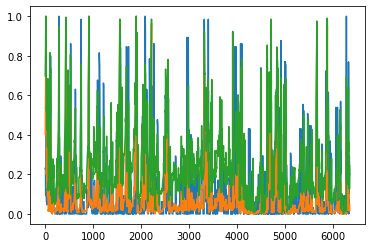

In [9]:
pyplot.plot(dataset)

In [10]:
dataset=pd.DataFrame(dataset)
dataset.dropna(inplace=True)
dataset.columns=['rain','flow','level']
n_hours =6
out_hour=5
values =dataset.values
values = values.astype('float32')
reframed = series_to_supervised(values, n_hours, out_hour)
print(reframed.shape)
trainx_column=n_hours*3
pred_columns=reframed.shape[1]-trainx_column
for i in range(out_hour):
    reframed.drop(reframed.columns[[-3-i,-2-i]], axis=1, inplace=True)
print(reframed.head())
values = reframed.values
train_size  = int(len(dataset) * 0.50)
val_size=int(len(dataset) * 0.75)
train_X, train_y = values[0:train_size, :-out_hour], values[0:train_size,-out_hour: ]
val_X, val_y=values[train_size:val_size, :-out_hour], values[train_size:val_size,-out_hour: ]
test_X, test_y = values[val_size:, :-out_hour], values[val_size:,-out_hour:]
#for last hour
#train_X, train_y = values[train_size:val_size, :-out_hour], values[train_size:val_size,-1 ]  #for only last hour
#val_X, val_y=values[train_size:val_size, :-out_hour], values[train_size:val_size,-1 ]
#test_X, test_y = values[val_size:, :-out_hour], values[val_size:,-1]
print(train_X, train_y)
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))


(6341, 33)
    var1(t-6)  var2(t-6)  var3(t-6)  var1(t-5)  var2(t-5)  var3(t-5)  \
6    0.230769   0.401887   0.699029   0.230769   0.438261   0.723301   
7    0.230769   0.438261   0.723301   0.230769   0.476275   0.747573   
8    0.230769   0.476275   0.747573   0.230769   0.500068   0.762136   
9    0.230769   0.500068   0.762136   0.230769   0.524545   0.776699   
10   0.230769   0.524545   0.776699   0.215385   0.524545   0.776699   

    var1(t-4)  var2(t-4)  var3(t-4)  var1(t-3)  ...  var2(t-2)  var3(t-2)  \
6    0.230769   0.476275   0.747573   0.230769  ...   0.524545   0.776699   
7    0.230769   0.500068   0.762136   0.230769  ...   0.524545   0.776699   
8    0.230769   0.524545   0.776699   0.215385  ...   0.549980   0.791262   
9    0.215385   0.524545   0.776699   0.123077  ...   0.603309   0.820388   
10   0.123077   0.549980   0.791262   0.092308  ...   0.650485   0.844660   

    var1(t-1)  var2(t-1)  var3(t-1)   var3(t)  var3(t+1)  var3(t+2)  \
6    0.215385   0.5245

In [11]:
print(train_X, train_y)

[[[0.23076923 0.40188706 0.69902915 ... 0.21538462 0.5245453  0.776699  ]]

 [[0.23076923 0.43826064 0.723301   ... 0.12307692 0.5499795  0.79126215]]

 [[0.23076923 0.47627512 0.74757284 ... 0.09230769 0.60330915 0.8203884 ]]

 ...

 [[0.         0.04321072 0.23300971 ... 0.         0.04321072 0.23300971]]

 [[0.         0.04321072 0.23300971 ... 0.         0.04498838 0.23786408]]

 [[0.         0.04321072 0.23300971 ... 0.         0.04662929 0.24271844]]] [[0.79126215 0.8203884  0.8446602  0.8737864  0.89805824]
 [0.8203884  0.8446602  0.8737864  0.89805824 0.93203884]
 [0.8446602  0.8737864  0.89805824 0.93203884 0.9660194 ]
 ...
 [0.23786408 0.24271844 0.24757281 0.24757281 0.24757281]
 [0.24271844 0.24757281 0.24757281 0.24757281 0.2184466 ]
 [0.24757281 0.24757281 0.24757281 0.2184466  0.23300971]]


In [12]:
print(train_X.shape, train_y.shape, val_X.shape, val_y.shape)

(3175, 1, 18) (3175, 5) (1588, 1, 18) (1588, 5)


In [13]:
randomState = 46
np.random.seed(randomState)
#tensorflow.random.set_random_seed(randomState)
tensorflow.random.set_seed(randomState)
model = Sequential()
model.add(GRU(15,input_shape=(train_X.shape[1], train_X.shape[2])))
#model.add(Dense(22))
#model.add(Activation('relu'))    
model.add(Dense(out_hour,activation = "sigmoid"))
opt=tensorflow.keras.optimizers.Adam(learning_rate=0.001)
#    opt=tensorflow.keras.optimizers.Adam(learning_rate=0.00075)
model.compile(loss='mae', optimizer=opt,metrics=['mse','mae',tensorflow.keras.metrics.RootMeanSquaredError()])
history = model.fit(train_X, train_y,validation_data=(val_X, val_y), epochs=500, batch_size=100,verbose=1,shuffle=False)
score = model.evaluate(test_X, test_y, verbose=0)
out=model.predict(test_X)

Train on 3175 samples, validate on 1588 samples
Epoch 1/500
3175/3175 [==============================] - 2s 571us/sample - loss: 0.2528 - mse: 0.0767 - mae: 0.2528 - root_mean_squared_error: 0.2769 - val_loss: 0.2630 - val_mse: 0.0854 - val_mae: 0.2630 - val_root_mean_squared_error: 0.2923
Epoch 2/500
3175/3175 [==============================] - 0s 29us/sample - loss: 0.2296 - mse: 0.0651 - mae: 0.2296 - root_mean_squared_error: 0.2552 - val_loss: 0.2394 - val_mse: 0.0721 - val_mae: 0.2394 - val_root_mean_squared_error: 0.2685
Epoch 3/500
3175/3175 [==============================] - ETA: 0s - loss: 0.2095 - mse: 0.0578 - mae: 0.2095 - root_mean_squared_error: 0.240 - 0s 29us/sample - loss: 0.2064 - mse: 0.0551 - mae: 0.2064 - root_mean_squared_error: 0.2347 - val_loss: 0.2158 - val_mse: 0.0605 - val_mae: 0.2158 - val_root_mean_squared_error: 0.2460
Epoch 4/500
3175/3175 [==============================] - 0s 43us/sample - loss: 0.1852 - mse: 0.0477 - mae: 0.1852 - root_mean_squared_erro

3175/3175 [==============================] - 0s 29us/sample - loss: 0.0545 - mse: 0.0086 - mae: 0.0545 - root_mean_squared_error: 0.0930 - val_loss: 0.0604 - val_mse: 0.0097 - val_mae: 0.0604 - val_root_mean_squared_error: 0.0987
Epoch 35/500
3175/3175 [==============================] - 0s 29us/sample - loss: 0.0541 - mse: 0.0086 - mae: 0.0541 - root_mean_squared_error: 0.0926 - val_loss: 0.0601 - val_mse: 0.0097 - val_mae: 0.0601 - val_root_mean_squared_error: 0.0983
Epoch 36/500
3175/3175 [==============================] - 0s 27us/sample - loss: 0.0539 - mse: 0.0085 - mae: 0.0539 - root_mean_squared_error: 0.0922 - val_loss: 0.0598 - val_mse: 0.0096 - val_mae: 0.0598 - val_root_mean_squared_error: 0.0980
Epoch 37/500
3175/3175 [==============================] - 0s 28us/sample - loss: 0.0536 - mse: 0.0084 - mae: 0.0536 - root_mean_squared_error: 0.0918 - val_loss: 0.0595 - val_mse: 0.0095 - val_mae: 0.0595 - val_root_mean_squared_error: 0.0976
Epoch 38/500
3175/3175 [=================

Epoch 68/500
3175/3175 [==============================] - 0s 27us/sample - loss: 0.0482 - mse: 0.0075 - mae: 0.0482 - root_mean_squared_error: 0.0864 - val_loss: 0.0545 - val_mse: 0.0087 - val_mae: 0.0545 - val_root_mean_squared_error: 0.0931
Epoch 69/500
3175/3175 [==============================] - 0s 28us/sample - loss: 0.0482 - mse: 0.0075 - mae: 0.0482 - root_mean_squared_error: 0.0863 - val_loss: 0.0544 - val_mse: 0.0087 - val_mae: 0.0544 - val_root_mean_squared_error: 0.0930
Epoch 70/500
3175/3175 [==============================] - 0s 28us/sample - loss: 0.0481 - mse: 0.0074 - mae: 0.0481 - root_mean_squared_error: 0.0863 - val_loss: 0.0543 - val_mse: 0.0086 - val_mae: 0.0543 - val_root_mean_squared_error: 0.0929
Epoch 71/500
3175/3175 [==============================] - 0s 28us/sample - loss: 0.0480 - mse: 0.0074 - mae: 0.0480 - root_mean_squared_error: 0.0862 - val_loss: 0.0542 - val_mse: 0.0086 - val_mae: 0.0542 - val_root_mean_squared_error: 0.0929
Epoch 72/500
3175/3175 [====

3175/3175 [==============================] - 0s 28us/sample - loss: 0.0456 - mse: 0.0071 - mae: 0.0456 - root_mean_squared_error: 0.0844 - val_loss: 0.0514 - val_mse: 0.0083 - val_mae: 0.0514 - val_root_mean_squared_error: 0.0912
Epoch 102/500
3175/3175 [==============================] - 0s 28us/sample - loss: 0.0455 - mse: 0.0071 - mae: 0.0455 - root_mean_squared_error: 0.0843 - val_loss: 0.0514 - val_mse: 0.0083 - val_mae: 0.0514 - val_root_mean_squared_error: 0.0912
Epoch 103/500
3175/3175 [==============================] - 0s 27us/sample - loss: 0.0455 - mse: 0.0071 - mae: 0.0455 - root_mean_squared_error: 0.0843 - val_loss: 0.0513 - val_mse: 0.0083 - val_mae: 0.0513 - val_root_mean_squared_error: 0.0911
Epoch 104/500
3175/3175 [==============================] - 0s 28us/sample - loss: 0.0454 - mse: 0.0071 - mae: 0.0454 - root_mean_squared_error: 0.0842 - val_loss: 0.0512 - val_mse: 0.0083 - val_mae: 0.0512 - val_root_mean_squared_error: 0.0911
Epoch 105/500
3175/3175 [=============

Epoch 135/500
3175/3175 [==============================] - 0s 28us/sample - loss: 0.0440 - mse: 0.0070 - mae: 0.0440 - root_mean_squared_error: 0.0835 - val_loss: 0.0496 - val_mse: 0.0082 - val_mae: 0.0496 - val_root_mean_squared_error: 0.0906
Epoch 136/500
3175/3175 [==============================] - 0s 29us/sample - loss: 0.0440 - mse: 0.0070 - mae: 0.0440 - root_mean_squared_error: 0.0835 - val_loss: 0.0496 - val_mse: 0.0082 - val_mae: 0.0496 - val_root_mean_squared_error: 0.0906
Epoch 137/500
3175/3175 [==============================] - 0s 27us/sample - loss: 0.0440 - mse: 0.0070 - mae: 0.0440 - root_mean_squared_error: 0.0835 - val_loss: 0.0496 - val_mse: 0.0082 - val_mae: 0.0496 - val_root_mean_squared_error: 0.0905
Epoch 138/500
3175/3175 [==============================] - 0s 28us/sample - loss: 0.0439 - mse: 0.0070 - mae: 0.0439 - root_mean_squared_error: 0.0835 - val_loss: 0.0495 - val_mse: 0.0082 - val_mae: 0.0495 - val_root_mean_squared_error: 0.0905
Epoch 139/500
3175/3175 

3175/3175 [==============================] - 0s 28us/sample - loss: 0.0433 - mse: 0.0069 - mae: 0.0433 - root_mean_squared_error: 0.0833 - val_loss: 0.0487 - val_mse: 0.0082 - val_mae: 0.0487 - val_root_mean_squared_error: 0.0903
Epoch 169/500
3175/3175 [==============================] - 0s 28us/sample - loss: 0.0433 - mse: 0.0069 - mae: 0.0433 - root_mean_squared_error: 0.0833 - val_loss: 0.0486 - val_mse: 0.0082 - val_mae: 0.0486 - val_root_mean_squared_error: 0.0903
Epoch 170/500
3175/3175 [==============================] - 0s 27us/sample - loss: 0.0433 - mse: 0.0069 - mae: 0.0433 - root_mean_squared_error: 0.0833 - val_loss: 0.0486 - val_mse: 0.0082 - val_mae: 0.0486 - val_root_mean_squared_error: 0.0903
Epoch 171/500
3175/3175 [==============================] - 0s 28us/sample - loss: 0.0433 - mse: 0.0069 - mae: 0.0433 - root_mean_squared_error: 0.0833 - val_loss: 0.0486 - val_mse: 0.0082 - val_mae: 0.0486 - val_root_mean_squared_error: 0.0903
Epoch 172/500
3175/3175 [=============

3175/3175 [==============================] - 0s 27us/sample - loss: 0.0429 - mse: 0.0069 - mae: 0.0429 - root_mean_squared_error: 0.0831 - val_loss: 0.0480 - val_mse: 0.0081 - val_mae: 0.0480 - val_root_mean_squared_error: 0.0901
Epoch 202/500
3175/3175 [==============================] - 0s 27us/sample - loss: 0.0429 - mse: 0.0069 - mae: 0.0429 - root_mean_squared_error: 0.0831 - val_loss: 0.0480 - val_mse: 0.0081 - val_mae: 0.0480 - val_root_mean_squared_error: 0.0901
Epoch 203/500
3175/3175 [==============================] - 0s 28us/sample - loss: 0.0428 - mse: 0.0069 - mae: 0.0428 - root_mean_squared_error: 0.0831 - val_loss: 0.0480 - val_mse: 0.0081 - val_mae: 0.0480 - val_root_mean_squared_error: 0.0901
Epoch 204/500
3175/3175 [==============================] - 0s 27us/sample - loss: 0.0428 - mse: 0.0069 - mae: 0.0428 - root_mean_squared_error: 0.0831 - val_loss: 0.0479 - val_mse: 0.0081 - val_mae: 0.0479 - val_root_mean_squared_error: 0.0900
Epoch 205/500
3175/3175 [=============

3175/3175 [==============================] - 0s 28us/sample - loss: 0.0426 - mse: 0.0069 - mae: 0.0426 - root_mean_squared_error: 0.0829 - val_loss: 0.0475 - val_mse: 0.0081 - val_mae: 0.0475 - val_root_mean_squared_error: 0.0899
Epoch 235/500
3175/3175 [==============================] - 0s 27us/sample - loss: 0.0426 - mse: 0.0069 - mae: 0.0426 - root_mean_squared_error: 0.0829 - val_loss: 0.0475 - val_mse: 0.0081 - val_mae: 0.0475 - val_root_mean_squared_error: 0.0899
Epoch 236/500
3175/3175 [==============================] - 0s 27us/sample - loss: 0.0425 - mse: 0.0069 - mae: 0.0425 - root_mean_squared_error: 0.0829 - val_loss: 0.0475 - val_mse: 0.0081 - val_mae: 0.0475 - val_root_mean_squared_error: 0.0899
Epoch 237/500
3175/3175 [==============================] - 0s 28us/sample - loss: 0.0425 - mse: 0.0069 - mae: 0.0425 - root_mean_squared_error: 0.0829 - val_loss: 0.0475 - val_mse: 0.0081 - val_mae: 0.0475 - val_root_mean_squared_error: 0.0899
Epoch 238/500
3175/3175 [=============

Epoch 267/500
3175/3175 [==============================] - 0s 32us/sample - loss: 0.0423 - mse: 0.0069 - mae: 0.0423 - root_mean_squared_error: 0.0828 - val_loss: 0.0472 - val_mse: 0.0081 - val_mae: 0.0472 - val_root_mean_squared_error: 0.0899
Epoch 268/500
3175/3175 [==============================] - 0s 31us/sample - loss: 0.0423 - mse: 0.0069 - mae: 0.0423 - root_mean_squared_error: 0.0828 - val_loss: 0.0472 - val_mse: 0.0081 - val_mae: 0.0472 - val_root_mean_squared_error: 0.0899
Epoch 269/500
3175/3175 [==============================] - 0s 31us/sample - loss: 0.0423 - mse: 0.0069 - mae: 0.0423 - root_mean_squared_error: 0.0828 - val_loss: 0.0472 - val_mse: 0.0081 - val_mae: 0.0472 - val_root_mean_squared_error: 0.0899
Epoch 270/500
3175/3175 [==============================] - 0s 31us/sample - loss: 0.0423 - mse: 0.0069 - mae: 0.0423 - root_mean_squared_error: 0.0828 - val_loss: 0.0472 - val_mse: 0.0081 - val_mae: 0.0472 - val_root_mean_squared_error: 0.0898
Epoch 271/500
3175/3175 

3175/3175 [==============================] - 0s 30us/sample - loss: 0.0421 - mse: 0.0068 - mae: 0.0421 - root_mean_squared_error: 0.0827 - val_loss: 0.0470 - val_mse: 0.0081 - val_mae: 0.0470 - val_root_mean_squared_error: 0.0898
Epoch 301/500
3175/3175 [==============================] - 0s 31us/sample - loss: 0.0422 - mse: 0.0068 - mae: 0.0422 - root_mean_squared_error: 0.0828 - val_loss: 0.0470 - val_mse: 0.0081 - val_mae: 0.0470 - val_root_mean_squared_error: 0.0898
Epoch 302/500
3175/3175 [==============================] - 0s 31us/sample - loss: 0.0422 - mse: 0.0068 - mae: 0.0422 - root_mean_squared_error: 0.0827 - val_loss: 0.0469 - val_mse: 0.0081 - val_mae: 0.0469 - val_root_mean_squared_error: 0.0898
Epoch 303/500
3175/3175 [==============================] - 0s 30us/sample - loss: 0.0421 - mse: 0.0068 - mae: 0.0421 - root_mean_squared_error: 0.0827 - val_loss: 0.0469 - val_mse: 0.0081 - val_mae: 0.0469 - val_root_mean_squared_error: 0.0898
Epoch 304/500
3175/3175 [=============

3175/3175 [==============================] - 0s 31us/sample - loss: 0.0420 - mse: 0.0068 - mae: 0.0420 - root_mean_squared_error: 0.0826 - val_loss: 0.0468 - val_mse: 0.0081 - val_mae: 0.0468 - val_root_mean_squared_error: 0.0897
Epoch 334/500
3175/3175 [==============================] - 0s 31us/sample - loss: 0.0420 - mse: 0.0068 - mae: 0.0420 - root_mean_squared_error: 0.0826 - val_loss: 0.0468 - val_mse: 0.0081 - val_mae: 0.0468 - val_root_mean_squared_error: 0.0898
Epoch 335/500
3175/3175 [==============================] - 0s 31us/sample - loss: 0.0420 - mse: 0.0068 - mae: 0.0420 - root_mean_squared_error: 0.0826 - val_loss: 0.0468 - val_mse: 0.0081 - val_mae: 0.0468 - val_root_mean_squared_error: 0.0898
Epoch 336/500
3175/3175 [==============================] - 0s 31us/sample - loss: 0.0420 - mse: 0.0068 - mae: 0.0420 - root_mean_squared_error: 0.0826 - val_loss: 0.0468 - val_mse: 0.0081 - val_mae: 0.0468 - val_root_mean_squared_error: 0.0898
Epoch 337/500
3175/3175 [=============

Epoch 367/500
3175/3175 [==============================] - 0s 31us/sample - loss: 0.0419 - mse: 0.0068 - mae: 0.0419 - root_mean_squared_error: 0.0825 - val_loss: 0.0466 - val_mse: 0.0081 - val_mae: 0.0466 - val_root_mean_squared_error: 0.0897
Epoch 368/500
3175/3175 [==============================] - 0s 32us/sample - loss: 0.0419 - mse: 0.0068 - mae: 0.0419 - root_mean_squared_error: 0.0825 - val_loss: 0.0466 - val_mse: 0.0081 - val_mae: 0.0466 - val_root_mean_squared_error: 0.0898
Epoch 369/500
3175/3175 [==============================] - 0s 32us/sample - loss: 0.0419 - mse: 0.0068 - mae: 0.0419 - root_mean_squared_error: 0.0825 - val_loss: 0.0466 - val_mse: 0.0081 - val_mae: 0.0466 - val_root_mean_squared_error: 0.0898
Epoch 370/500
3175/3175 [==============================] - 0s 31us/sample - loss: 0.0419 - mse: 0.0068 - mae: 0.0419 - root_mean_squared_error: 0.0825 - val_loss: 0.0466 - val_mse: 0.0081 - val_mae: 0.0466 - val_root_mean_squared_error: 0.0898
Epoch 371/500
3175/3175 

3175/3175 [==============================] - 0s 32us/sample - loss: 0.0418 - mse: 0.0068 - mae: 0.0418 - root_mean_squared_error: 0.0824 - val_loss: 0.0465 - val_mse: 0.0081 - val_mae: 0.0465 - val_root_mean_squared_error: 0.0898
Epoch 401/500
3175/3175 [==============================] - 0s 31us/sample - loss: 0.0418 - mse: 0.0068 - mae: 0.0418 - root_mean_squared_error: 0.0824 - val_loss: 0.0465 - val_mse: 0.0081 - val_mae: 0.0465 - val_root_mean_squared_error: 0.0898
Epoch 402/500
3175/3175 [==============================] - 0s 31us/sample - loss: 0.0418 - mse: 0.0068 - mae: 0.0418 - root_mean_squared_error: 0.0824 - val_loss: 0.0465 - val_mse: 0.0081 - val_mae: 0.0465 - val_root_mean_squared_error: 0.0898
Epoch 403/500
3175/3175 [==============================] - 0s 32us/sample - loss: 0.0418 - mse: 0.0068 - mae: 0.0418 - root_mean_squared_error: 0.0824 - val_loss: 0.0465 - val_mse: 0.0081 - val_mae: 0.0465 - val_root_mean_squared_error: 0.0898
Epoch 404/500
3175/3175 [=============

Epoch 434/500
3175/3175 [==============================] - 0s 33us/sample - loss: 0.0417 - mse: 0.0068 - mae: 0.0417 - root_mean_squared_error: 0.0823 - val_loss: 0.0464 - val_mse: 0.0081 - val_mae: 0.0464 - val_root_mean_squared_error: 0.0898
Epoch 435/500
3175/3175 [==============================] - 0s 35us/sample - loss: 0.0417 - mse: 0.0068 - mae: 0.0417 - root_mean_squared_error: 0.0823 - val_loss: 0.0464 - val_mse: 0.0081 - val_mae: 0.0464 - val_root_mean_squared_error: 0.0898
Epoch 436/500
3175/3175 [==============================] - 0s 32us/sample - loss: 0.0417 - mse: 0.0068 - mae: 0.0417 - root_mean_squared_error: 0.0823 - val_loss: 0.0464 - val_mse: 0.0081 - val_mae: 0.0464 - val_root_mean_squared_error: 0.0898
Epoch 437/500
3175/3175 [==============================] - 0s 32us/sample - loss: 0.0417 - mse: 0.0068 - mae: 0.0417 - root_mean_squared_error: 0.0823 - val_loss: 0.0464 - val_mse: 0.0081 - val_mae: 0.0464 - val_root_mean_squared_error: 0.0898
Epoch 438/500
3175/3175 

Epoch 467/500
3175/3175 [==============================] - 0s 31us/sample - loss: 0.0416 - mse: 0.0068 - mae: 0.0416 - root_mean_squared_error: 0.0822 - val_loss: 0.0464 - val_mse: 0.0081 - val_mae: 0.0464 - val_root_mean_squared_error: 0.0898
Epoch 468/500
3175/3175 [==============================] - 0s 31us/sample - loss: 0.0416 - mse: 0.0068 - mae: 0.0416 - root_mean_squared_error: 0.0822 - val_loss: 0.0464 - val_mse: 0.0081 - val_mae: 0.0464 - val_root_mean_squared_error: 0.0898
Epoch 469/500
3175/3175 [==============================] - 0s 31us/sample - loss: 0.0416 - mse: 0.0068 - mae: 0.0416 - root_mean_squared_error: 0.0822 - val_loss: 0.0464 - val_mse: 0.0081 - val_mae: 0.0464 - val_root_mean_squared_error: 0.0898
Epoch 470/500
3175/3175 [==============================] - 0s 31us/sample - loss: 0.0416 - mse: 0.0068 - mae: 0.0416 - root_mean_squared_error: 0.0822 - val_loss: 0.0464 - val_mse: 0.0081 - val_mae: 0.0464 - val_root_mean_squared_error: 0.0898
Epoch 471/500
3175/3175 

3175/3175 [==============================] - 0s 33us/sample - loss: 0.0416 - mse: 0.0067 - mae: 0.0416 - root_mean_squared_error: 0.0821 - val_loss: 0.0463 - val_mse: 0.0081 - val_mae: 0.0463 - val_root_mean_squared_error: 0.0898


The testing MAE loss is: 0.043824833
The testing MSE loss is: 0.007339268
The testing RMSE loss is: 0.08566953


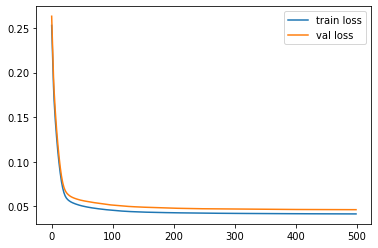

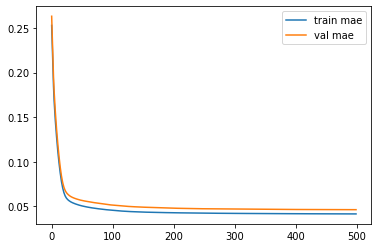

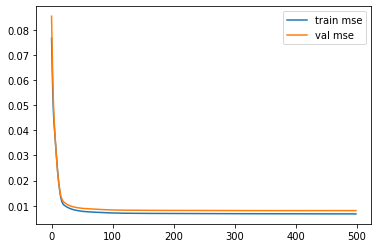

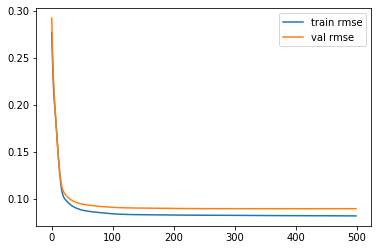

In [14]:
print('The testing MAE loss is:', str(score[2]))
print('The testing MSE loss is:', str(score[1]))
print('The testing RMSE loss is:', str(score[3]))
pyplot.plot(history.history['loss'], label='train loss')
pyplot.plot(history.history['val_loss'], label='val loss')
pyplot.legend()
pyplot.show()
pyplot.plot(history.history['mae'],label='train mae')
pyplot.plot(history.history['val_mae'],label='val mae')
pyplot.legend()
pyplot.show()
pyplot.plot(history.history['mse'],label='train mse')
pyplot.plot(history.history['val_mse'],label='val mse')
pyplot.legend()
pyplot.show()
pyplot.plot(history.history['root_mean_squared_error'],label='train rmse')
pyplot.plot(history.history['val_root_mean_squared_error'],label='val rmse')
pyplot.legend()
pyplot.show()

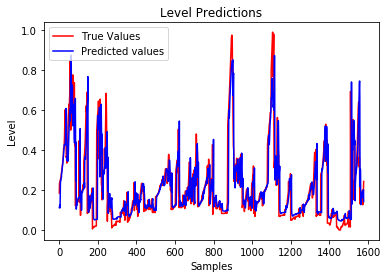

In [15]:
pyplot.plot(test_y[:,4],color='red', label='True Values')
pyplot.plot(out[:,4],color='blue',label='Predicted values')
pyplot.title("Level Predictions")
pyplot.legend(loc='upper left')
pyplot.xlabel("Samples")
pyplot.ylabel("Level")
pyplot.show()

In [16]:
dataset_test=pd.read_excel('F:\MS thesis data/Hopper Crossing.xlsx')
dataset_test=dataset_test.drop(['Date/Time','Flowd'],axis=1)
dataset_test.dropna(inplace=True)


(26285, 3)


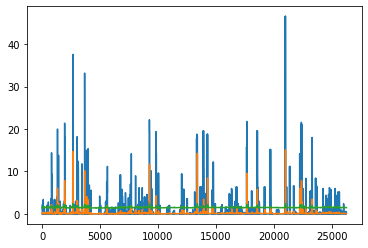

In [17]:
shape=np.shape(dataset_test)
print(shape)
pyplot.plot(dataset_test)


In [18]:
dataset_test

,Cumulative rainfall,Flow,Level
0,0.0,0.093,1.50
1,0.0,0.093,1.50
2,0.0,0.093,1.50
3,0.0,0.093,1.50
4,0.0,0.093,1.50
...,...,...,...
26280,0.2,0.080,1.49
26281,0.2,0.080,1.49
26282,0.2,0.080,1.49
26283,0.2,0.080,1.49


In [19]:
print('The std of original data is ' + str(np.std(dataset_test)))

The std of original data is Cumulative rainfall    2.451640
Flow                   0.520832
Level                  0.083204
dtype: float64


In [20]:
#Normalizing and removing outlier from Dataset
#Outliers removel
num=int((shape[0]*0.03)/2)
dataset_test=dataset_test.values
#dataset=np.array(dataset)
#pyplot.plot(dataset[:,0])
#pyplot.plot(dataset[:,1])
#pyplot.plot(dataset[:,2])
count=0
#for j in range(num):
while(count<num):
    
    maxi=dataset_test.max(axis=0)
#    print(maxi)
    ind1=np.argwhere(dataset_test[:,0]== maxi[0])
    ind2=np.argwhere(dataset_test[:,1]== maxi[1])
    ind3=np.argwhere(dataset_test[:,2]== maxi[2])
    ind=np.append(ind1,ind2)
    ind=np.append(ind,ind3)
    index=[]
    for i in ind:
        if i not in index:
            index.append(i)
    count=count+len(index)
    dataset_test=np.delete(dataset_test,index,axis=0) 
#pyplot.plot(dataset[:,0])
#pyplot.plot(dataset[:,1])
#pyplot.plot(dataset[:,2])    
    
count=0
#for j in range(num):
while(count<num):
    
    mini=dataset_test.min(axis=0)
#    print(mini)
    ind1=np.argwhere(dataset_test[:,0]== mini[0])
    ind2=np.argwhere(dataset_test[:,1]== mini[1])
    ind3=np.argwhere(dataset_test[:,2]== mini[2])
    ind=np.append(ind1,ind2)
    ind=np.append(ind,ind3)
    index=[]
    for i in ind:
        if i not in index:
            index.append(i)
    count=count+len(index)
    dataset_test=np.delete(dataset_test,index,axis=0) 
#pyplot.plot(dataset[:,0])
#pyplot.plot(dataset[:,1])
#pyplot.plot(dataset[:,2]) 
print('The std of cleaned data is ' +str(np.std(dataset_test)))
min_max_scaler = preprocessing.MinMaxScaler()   #scaling values
dataset_test = min_max_scaler.fit_transform(dataset_test)

The std of cleaned data is 1.5154548293543502


In [21]:
dataset=pd.DataFrame(dataset)
dataset.dropna(inplace=True)
dataset.columns=['rain','flow','level']
n_hours =6
out_hour=5
values =dataset.values
values = values.astype('float32')
reframed = series_to_supervised(values, n_hours, out_hour)
print(reframed.shape)
trainx_column=n_hours*3
pred_columns=reframed.shape[1]-trainx_column
for i in range(out_hour):
    reframed.drop(reframed.columns[[-3-i,-2-i]], axis=1, inplace=True)
print(reframed.head())
values = reframed.values

#one hour
#test_X, test_y = values[:, :-out_hour], values[:,-1]


test_X, test_y = values[:, :-out_hour], values[:, -out_hour: ]


test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))





(6341, 33)
    var1(t-6)  var2(t-6)  var3(t-6)  var1(t-5)  var2(t-5)  var3(t-5)  \
6    0.230769   0.401887   0.699029   0.230769   0.438261   0.723301   
7    0.230769   0.438261   0.723301   0.230769   0.476275   0.747573   
8    0.230769   0.476275   0.747573   0.230769   0.500068   0.762136   
9    0.230769   0.500068   0.762136   0.230769   0.524545   0.776699   
10   0.230769   0.524545   0.776699   0.215385   0.524545   0.776699   

    var1(t-4)  var2(t-4)  var3(t-4)  var1(t-3)  ...  var2(t-2)  var3(t-2)  \
6    0.230769   0.476275   0.747573   0.230769  ...   0.524545   0.776699   
7    0.230769   0.500068   0.762136   0.230769  ...   0.524545   0.776699   
8    0.230769   0.524545   0.776699   0.215385  ...   0.549980   0.791262   
9    0.215385   0.524545   0.776699   0.123077  ...   0.603309   0.820388   
10   0.123077   0.549980   0.791262   0.092308  ...   0.650485   0.844660   

    var1(t-1)  var2(t-1)  var3(t-1)   var3(t)  var3(t+1)  var3(t+2)  \
6    0.215385   0.5245

In [22]:
score = model.evaluate(test_X, test_y, verbose=0)
out=model.predict(test_X)

In [23]:
print('The testing MAE loss is:', str(score[2]))
print('The testing MSE loss is:', str(score[1]))
print('The testing RMSE loss is:', str(score[3]))

The testing MAE loss is: 0.043276906
The testing MSE loss is: 0.007226995
The testing RMSE loss is: 0.085011736


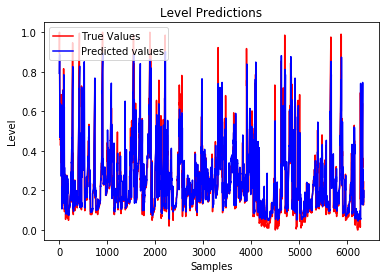

In [24]:
pyplot.plot(test_y[:,4],color='red', label='True Values')
pyplot.plot(out[:,4],color='blue',label='Predicted values')
pyplot.title("Level Predictions")
pyplot.legend(loc='upper left')
pyplot.xlabel("Samples")
pyplot.ylabel("Level")
pyplot.show()